### npy load

In [1]:
import matplotlib.pyplot as plt
import cv2, os, glob
import numpy as np
from PIL import Image

In [2]:
train_images =  np.load('/home/nas/data/eunju/Industrial/leather/train_images.npy')
train_labels =  np.load('/home/nas/data/eunju/Industrial/leather/train_labels.npy')

val_images =  np.load('/home/nas/data/eunju/Industrial/leather/val_images.npy')
val_labels =  np.load('/home/nas/data/eunju/Industrial/leather/val_labels.npy')

test_images =  np.load('/home/nas/data/eunju/Industrial/leather/test_images.npy')
test_labels =  np.load('/home/nas/data/eunju/Industrial/leather/test_labels.npy')

### 6:2:2 비율
- 총 92개

In [12]:
print("train_images:", train_images.shape)
print("train_labels:", train_labels.shape)
print("test_images: ", test_images.shape)
print("test_labels: ", test_labels.shape)
print("val_images:  ", val_images.shape)
print("val_labels:  ", val_labels.shape)

train_images: (55, 256, 256, 3)
train_labels: (55, 256, 256)
test_images:  (19, 256, 256, 3)
test_labels:  (19, 256, 256)
val_images:   (18, 256, 256, 3)
val_labels:   (18, 256, 256)


### image 확인

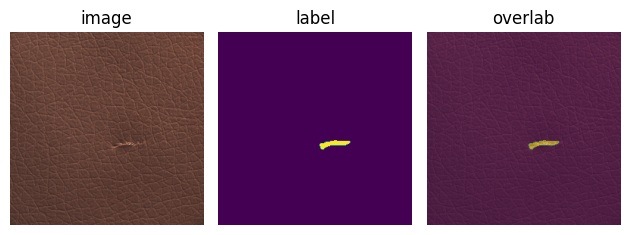

In [35]:
plt.subplot(131); plt.imshow(train_images[0]); plt.title("image") ; plt.axis(False)
plt.subplot(132); plt.imshow(train_labels[0]); plt.title("label") ; plt.axis(False)
plt.subplot(133); plt.imshow(train_images[0]); plt.axis(False)
plt.subplot(133); plt.imshow(train_labels[0], alpha=0.5) ;plt.title('overlab') ; plt.axis(False)
plt.tight_layout() ; plt.show()

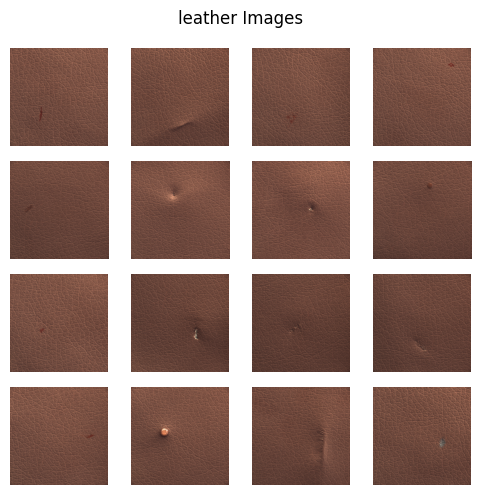

In [11]:
import random

# 랜덤 16개 선택
random_indices = random.sample(range(test_images.shape[0]), 16)
fig, axs = plt.subplots(4, 4, figsize=(5, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(test_images[random_indices[i]])
    ax.axis('off')
    
plt.suptitle("leather Images")
plt.tight_layout()
plt.show()

### 네트워크

In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# Middle
conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)

# Decoder
up8 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv1], axis=-1)
conv8 = Conv2D(8, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv8)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 8)  224         ['input_3[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_14[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 8)  0          ['conv2d_15[0][0]']        

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=300, batch_size=32)

Epoch 1/300
2/2 [==============================] - 1s 208ms/step - loss: 0.6804 - accuracy: 0.8834 - val_loss: 0.6585 - val_accuracy: 0.9849
Epoch 2/300
2/2 [==============================] - 0s 82ms/step - loss: 0.6522 - accuracy: 0.9917 - val_loss: 0.6292 - val_accuracy: 0.9849
Epoch 3/300
2/2 [==============================] - 0s 71ms/step - loss: 0.6206 - accuracy: 0.9918 - val_loss: 0.5896 - val_accuracy: 0.9849
Epoch 4/300
2/2 [==============================] - 0s 84ms/step - loss: 0.5772 - accuracy: 0.9918 - val_loss: 0.5339 - val_accuracy: 0.9849
Epoch 5/300
2/2 [==============================] - 0s 82ms/step - loss: 0.5163 - accuracy: 0.9918 - val_loss: 0.4581 - val_accuracy: 0.9849
Epoch 6/300
2/2 [==============================] - 0s 79ms/step - loss: 0.4346 - accuracy: 0.9918 - val_loss: 0.3636 - val_accuracy: 0.9849
Epoch 7/300
2/2 [==============================] - 0s 84ms/step - loss: 0.3344 - accuracy: 0.9918 - val_loss: 0.2582 - val_accuracy: 0.9849
Epoch 8/300
2/2 [==

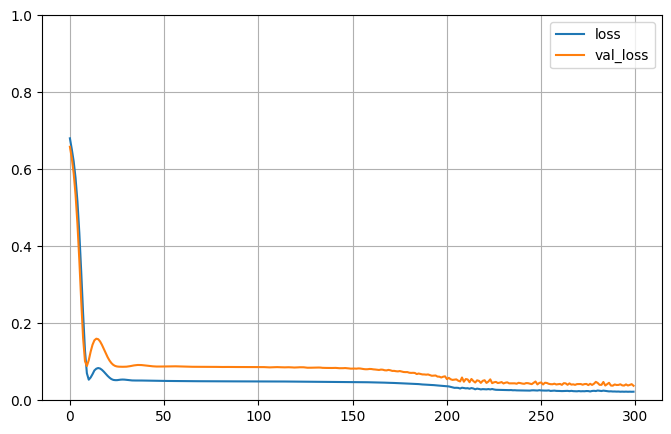

(<matplotlib.legend.Legend at 0x7f6f707551c0>, None, None)

In [18]:
plot_target = ['loss', 'val_loss']

plt.figure(figsize=(8,5))

for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.ylim(0,1)
plt.legend(), plt.grid(), plt.show()

<br>

### evaluate

In [19]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

1/1 - 0s - loss: 0.0170 - accuracy: 0.9959 - 115ms/epoch - 115ms/step


In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

pred = model.predict(val_images)
pred = (pred > 0.5).astype(int)  # 임계값 설정

# 실제 라벨과 예측 라벨을 1차원 배열로 변환
true_labels = val_labels.flatten()
pred_labels = pred.flatten()

precision = precision_score(true_labels, pred_labels)
print("정밀도:", round(precision,3))

recall = recall_score(true_labels, pred_labels);
print("재현율:", round(recall,3))

f1 = f1_score(true_labels, pred_labels)
print("F1점수:", round(f1,3))

정밀도: 0.747
재현율: 0.475
F1점수: 0.581


diff:  256


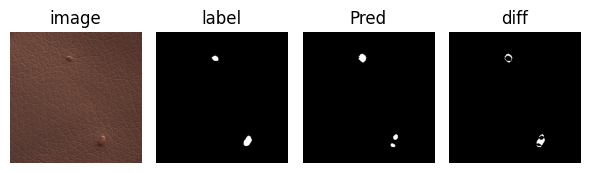

In [21]:
num = 1

test_image = test_images[num]
test_label = test_labels[num]
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
prediction = np.where(prediction > 0.5, 1, 0)
diff= abs(test_label-prediction[:,:,0])
count = np.count_nonzero(diff==1)
print("diff: ",count)

plt.figure(figsize=(6,4))
plt.subplot(141) ;  plt.imshow(test_image, cmap='gray') ; plt.title('image');plt.axis('off')
plt.subplot(142) ;  plt.imshow(test_label, cmap='gray') ; plt.title('label'); plt.axis('off')
plt.subplot(143) ;  plt.imshow(prediction, cmap='gray') ; plt.title('Pred'); plt.axis('off')
plt.subplot(144) ; plt.imshow(diff, cmap='gray'); plt.title('diff') ; plt.axis('off')
plt.tight_layout();plt.show()

### test dataset에서 틀린 픽셀 수

In [25]:
test_images.shape

(19, 256, 256, 3)

In [24]:
diff_counts = []

for i in range(len(test_images)):
    test_image = test_images[i]
    test_label = test_labels[i]
    prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
    prediction = np.where(prediction > 0.5, 1, 0)
    diff = abs(test_label-prediction[:,:,0])
    count = np.count_nonzero(diff==1)
    diff_counts.append(count)

total = sum(diff_counts)
print("total diff: ", total)

total diff:  5043


<br>

### 모델 저장

In [26]:
#model.save('.../seg.h5')